# ETL dos Dados (Base de Leads)

#### Este notebook documenta o processo de extração, transformação e carregamento (ETL) de dados provenientes de uma base de leads de um arquivo excel. Embora os dados sejam fictícios, o objetivo é demonstrar técnicas de ETL utilizando Python e bibliotecas como Pandas, NumPy e outras. Além disso, o notebook aplica machine learning para classificar novos leads com base nos leads convertidos, atribuindo uma pontuação de classificação a cada lead aberto, ajudando a identificar melhores oportunidades de vendas.

In [118]:
# Importando as bibliotecas iniciais
from datetime import datetime
from datetime import date
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Base de Leads

Inicialmente, ao carregar a base de dados, foi realizada uma exploração preliminar para identificar possíveis ajustes que possam otimizar o processo de análise.

In [119]:
#carregando base de leads e visualizando as 5 primeiras linhas
df_leads_original = pd.read_excel("base_de_leads_origin.xlsx", sheet_name="Leads")
df_leads_original.head()

,Data de Criação,id_cliente,Estado,nº funcionários,Tipo de Empresa,Fundação Empresa,Código de Indicação,Persona
0,2021-12-01,23347,SP,5,Escritório Arquitetura/Interiores,2011.0,NaN,Arquitetura/Design
1,2021-12-01,23348,RS,1,Outros,2020.0,NaN,Outros
2,2021-12-01,23349,MG,6,Construtora,2021.0,NaN,Engenharia/Construção
3,2021-12-01,23350,TO,2,Estudante Arquitetura/Interiores,2021.0,NaN,Estudante
4,2021-12-01,23351,GO,4,Escritório Arquitetura/Interiores,2019.0,NaN,Arquitetura/Design


In [120]:
#verificando o tipo dos campos
df_leads_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11533 entries, 0 to 11532
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Data de Criação      11533 non-null  datetime64[ns]
 1   id_cliente           11533 non-null  int64         
 2   Estado               11283 non-null  object        
 3   nº funcionários      10863 non-null  object        
 4   Tipo de Empresa      11533 non-null  object        
 5   Fundação Empresa     11297 non-null  float64       
 6   Código de Indicação  431 non-null    object        
 7   Persona              11267 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 720.9+ KB


Ao analisar o output da célula anterior, chamou atenção o fato de o campo "n° funcionários" estar classificado como object, mesmo apresentando valores numéricos nas cinco primeiras linhas. Por isso, foi necessário investigar o caso mais a fundo.

In [121]:
# identificando possíveis valores não numéricos
valores_nao_numericos = df_leads_original[df_leads_original['nº funcionários'].apply(lambda x: isinstance(x, str))]
valores_nao_numericos['nº funcionários']

2063    Pequeno ou médio escritório de Arquitetura (En...
3950    Pequeno ou médio escritório de Arquitetura (En...
Name: nº funcionários, dtype: object

Foram encontrados dois casos em que os valores da coluna estavam armazenados como strings, o que explicava o motivo de a coluna ser tratada como object. A solução adotada foi converter esses valores para numéricos, já que a maioria das linhas continha valores numéricos, a fim de garantir a padronização da coluna. Além disso, foi criada uma nova coluna, "Faixa de Funcionários", com categorias do tipo "de X a Y funcionários", para ajudar na análise e na construção de modelos preditivos posteriores. Ambas as colunas foram mantidas para preservar o histórico dos dados. Em um ambiente de produção, esses ajustes seriam feitos entre as camadas (bronze, silver e gold), seguindo boas práticas de governança de dados.

In [122]:
# Função para converter valor em string para número, padronizando os valores da coluna "nº funcionários"
def substituir_valores_nao_numericos(valor):
    if pd.isnull(valor):  
        return np.nan
    try:
        # Tenta converter o tipo para número, caso o valor do campo já seja um número
        return int(valor)
    except ValueError:
        # Se não for número, extrai os números presentes na possível string("de 10 a 21 funcionários")
        numeros = [int(n) for n in str(valor).split() if n.isdigit()]
        if len(numeros) >= 2:  # Calcula a média dos números extraídos e arredonda para o inteiro mais próximo
            return int(round(np.mean(numeros)))
        elif len(numeros) == 1:  # Caso a lista de números tenha apenas um número, retorna o próprio número
            return numeros[0]
        else:  # Se não encontrar nenhum numero, retorna NaN(Not a Number)
            return np.nan

# Criar uma cópia do DataFrame original para salvar as alterações, de modo a manter um histórico das tabelas.
# Nessa cópia será inculido não somente o ajuste acima, mas todos referentes a modificações e criações de colunas
# em relação ao arquivo original.
df_leads_ajustes = df_leads_original.copy()

# Aplica a função para corrigir a coluna na nova versão da tabela
df_leads_ajustes['nº funcionários'] = df_leads_original['nº funcionários'].apply(substituir_valores_nao_numericos)


Além da transformação mencionada, a coluna "nº Funcionários" passou por outros ajustes para garantir a consistência dos dados. Foram identificados e removidos valores inconsistentes, como números negativos, que não fazem sentido nesse contexto. Além disso, todos os valores nulos foram preenchidos com "-1", adotando um valor padrão para indicar a ausência de informação.

In [123]:
#verificando valores nulos em cada campo, os demais campos também serão tratados posteriormente
valores_nulos = df_leads_ajustes.isnull().sum()
print(valores_nulos)


Data de Criação            0
id_cliente                 0
Estado                   250
nº funcionários          670
Tipo de Empresa            0
Fundação Empresa         236
Código de Indicação    11102
Persona                  266
dtype: int64


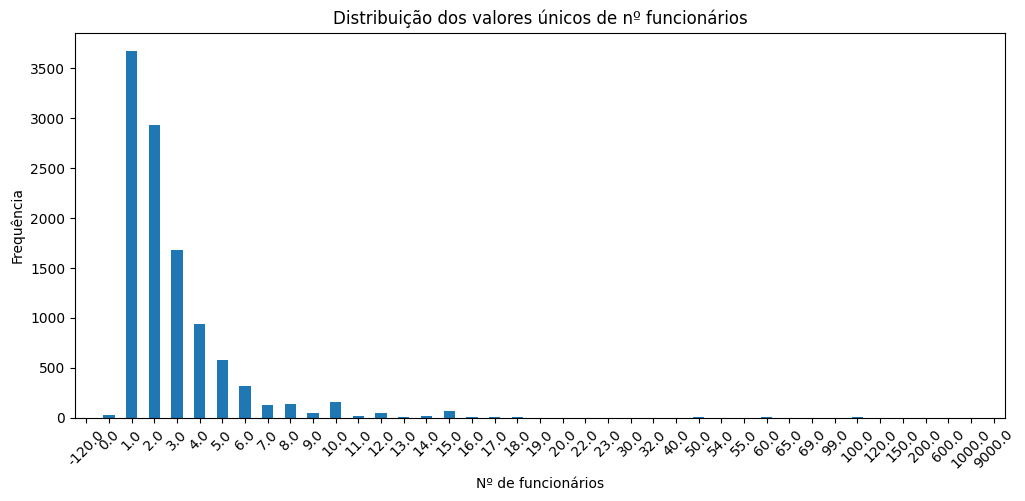

In [124]:
#visualizando distribuição dos valores para o campo "nº funcionários", ajudando a indentificar possíveis
#inconsistências como o valor negativo "-120", esse processo também foi feito para outros campos posteriormente.
df_leads_ajustes['nº funcionários'].value_counts().sort_index().plot(kind='bar', figsize=(12, 5))
plt.xlabel("Nº de funcionários")
plt.ylabel("Frequência")
plt.title("Distribuição dos valores únicos de nº funcionários")
plt.xticks(rotation=45)  # Rotaciona os rótulos para melhor visualização
plt.show()

In [125]:
# Alterar valores inconsistentes ("NaN" e menores que 1) para o valor padrão(-1)
df_leads_ajustes.loc[df_leads_ajustes['nº funcionários'] < 1, 'nº funcionários'] = -1
df_leads_ajustes['nº funcionários'].fillna(-1, inplace=True)

C:\Users\55359\AppData\Local\Temp\ipykernel_4764\35329099.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_leads_ajustes['nº funcionários'].fillna(-1, inplace=True)


Após os ajustes na coluna "nº funcionários", foi possível criar a coluna auxiliar "Faixa de Funcionários", conforme mencionado anteriormente.

In [126]:
def categorizar_faixa_funcionarios(n):
    if n == -1 or pd.isnull(n):  
        return "Não Informado"
    elif n <= 5:
        return "De 1 a 5 funcionários"
    elif n <= 10:
        return "De 6 a 10 funcionários"
    elif n <= 20:
        return "De 11 a 20 funcionários"
    elif n <= 50:
        return "De 21 a 50 funcionários"
    elif n <= 100:
        return "De 51 a 100 funcionários"
    elif n <= 500:
        return "De 101 a 500 funcionários"
    else:
        return "Mais de 500 funcionários"

# Criar a nova coluna aplicando a função
df_leads_ajustes["Faixa de Funcionários"] = df_leads_ajustes["nº funcionários"].apply(categorizar_faixa_funcionarios)

# Verificar a distribuição
df_leads_ajustes["Faixa de Funcionários"].value_counts()

Faixa de Funcionários
De 1 a 5 funcionários        9801
De 6 a 10 funcionários        803
Não Informado                 701
De 11 a 20 funcionários       186
De 51 a 100 funcionários       18
De 21 a 50 funcionários        17
Mais de 500 funcionários        4
De 101 a 500 funcionários       3
Name: count, dtype: int64

Após o tratamento da coluna "nº funcionários", foi realizada a padronização das colunas "Persona" e "Tipo de Empresa", que apresentavam problemas semelhantes. Dentre os principais problemas identificados, havia a duplicidade de categorias devido a erros de ortografia, como "Empreteiro" e "Empreiteiro", além de categorias registradas de formas diferentes, como "Design" e "Arquitetura/Design", sendo que a segunda já englobava a primeira na maior parte dos registros.

Para corrigir essas inconsistências, foi utilizado um algoritmo de similaridade da biblioteca RapidFuzz, que compara cada categoria com um conjunto de valores corretos pré-definidos. Quando a similaridade entre um valor encontrado e uma categoria correta atinge um determinado limite, o valor é atualizado para a versão padronizada. Dessa forma, garantimos maior consistência nos dados, eliminando redundâncias e unificando as informações para uma análise mais precisa.

In [127]:
# Verificando a distribuição de valores na coluna "Persona" e "Tipo de Empresa", incluindo categorias com erros
df_persona_dist = df_leads_ajustes['Persona'].value_counts().reset_index()
df_persona_dist.columns = ['Persona', 'Contagem']

df_tipo_empresa_dist = df_leads_ajustes['Tipo de Empresa'].value_counts().reset_index()
df_tipo_empresa_dist.columns = ['Tipo de Empresa', 'Contagem']

# Exibindo ambas as tabelas
df_persona_dist, df_tipo_empresa_dist


(                  Persona  Contagem
 0      Arquitetura/Design      7609
 1               Estudante      1174
 2   Engenharia/Construção      1136
 3                  Outros      1035
 4           Não Informado       300
 5   Engenharia/Construcao         3
 6             Arquitetura         3
 7              Engenharia         2
 8               estudante         1
 9              Construção         1
 10                 Design         1
 11      Arquitetra/Design         1
 12      Arquitetura/Desig         1,
                       Tipo de Empresa  Contagem
 0   Escritório Arquitetura/Interiores      7615
 1    Estudante Arquitetura/Interiores      1175
 2                              Outros       947
 3                       Não Informado       566
 4                  Empresa de Reforma       541
 5                         Construtora       504
 6                         Empreiteiro        94
 7                   Móveis Planejados        75
 8                          Fornecedor  

In [128]:
# Importando a biblioteca utilizada para comparação de similaridade entre strings
from rapidfuzz import fuzz, process  

# Listas de categorias corretas para as colunas "Persona" e "Tipo de Empresa"
personas = ["Arquitetura/Design", "Engenharia/Construção", "Estudante", "Não Informado", "Outros"]  
tipo_de_empresa = ["Construtora", "Empreiteiro", "Escritório Arquitetura/Interiores", 
                   "Empresa de Reformas", "Estudante Arquitetura/Interiores", "Fornecedor",
                   "Móveis Planejados", "Outros"]  

# Função genérica para corrigir valores com base na similaridade
def corrigir_categorias(valor, lista_categorias, limite_similaridade):
    """
    Corrige valores categóricos comparando com uma lista de categorias corretas utilizando similaridade.
    
    Parâmetros:
    valor (str): Valor a ser corrigido.
    lista_categorias (list): Lista de categorias corretas.
    limite_similaridade (int): Valor mínimo de similaridade para considerar uma correspondência válida.

    Retorno:
    str: Valor corrigido ou valor original, se nenhuma correspondência satisfatória for encontrada.
    """
    if pd.isnull(valor):  # Verifica se o valor é nulo
        return "Não Informado"

    # Encontra a melhor correspondência usando RapidFuzz
    melhor_correspondencia = process.extractOne(valor, lista_categorias, scorer=fuzz.ratio)
    
    # Valida se a melhor correspondência atende ao limite de similaridade
    if melhor_correspondencia and melhor_correspondencia[1] >= limite_similaridade:
        return melhor_correspondencia[0]
    
    return valor  # Retorna o valor original se nenhuma correspondência adequada for encontrada

# Aplicando a função de correção para a coluna "Persona"
df_leads_ajustes['Persona'] = df_leads_ajustes['Persona'].apply(lambda x: corrigir_categorias(x, personas, 50))

# Aplicando a função de correção para a coluna "Tipo de Empresa"
df_leads_ajustes['Tipo de Empresa'] = df_leads_ajustes['Tipo de Empresa'].apply(lambda x: corrigir_categorias(x, tipo_de_empresa, 80))


In [129]:
# Verificando a distribuição de valores na coluna "Persona" e "Tipo de Empresa", após as correções
df_persona_dist = df_leads_ajustes['Persona'].value_counts().reset_index()
df_persona_dist.columns = ['Persona', 'Contagem']

df_tipo_empresa_dist = df_leads_ajustes['Tipo de Empresa'].value_counts().reset_index()
df_tipo_empresa_dist.columns = ['Tipo de Empresa', 'Contagem']

# Exibindo ambas as tabelas
df_persona_dist, df_tipo_empresa_dist


(                 Persona  Contagem
 0     Arquitetura/Design      7615
 1              Estudante      1175
 2  Engenharia/Construção      1142
 3                 Outros      1035
 4          Não Informado       566,
                      Tipo de Empresa  Contagem
 0  Escritório Arquitetura/Interiores      7615
 1   Estudante Arquitetura/Interiores      1175
 2                             Outros       947
 3                      Não Informado       566
 4                Empresa de Reformas       543
 5                        Construtora       504
 6                        Empreiteiro        95
 7                  Móveis Planejados        75
 8                         Fornecedor        13)

A coluna "Fundação Empresa", que contém o ano de fundação das empresas, passou por ajustes devido à presença de valores inconsistentes. Foram identificados casos com anos no futuro, como 2046, 2038 e 2036, além de registros onde o ano de fundação era posterior à data de criação do lead. Por exemplo, uma empresa com fundação em 2022, mas cujo lead foi criado em 2021, apresentava uma inconsistência temporal.

Além disso, a base de dados continha anos excessivamente antigos, como 1800, que não fazem sentido no contexto analisado. Também foram encontrados valores como "1", "4" e "22", além de valores negativos, que não representam um ano válido. Para garantir uma análise coerente, foram considerados apenas os anos a partir de 1930, visto que anos anteriores não são representativos para a realidade das empresas analisadas.

Para corrigir essas inconsistências, foi realizada uma validação cruzada entre o ano de fundação da empresa e a data de criação do lead. Se o ano de fundação fosse maior que o ano de criação do lead, ele era considerado inválido e substituído pelo valor "-1". Da mesma forma, anos irreais, valores negativos e registros não numéricos também foram padronizados como "-1".

Após essa limpeza, foi criada uma nova coluna categorizando a idade das empresas em faixas etárias, facilitando análises futuras e permitindo insights mais estruturados sobre a distribuição das empresas por tempo de mercado.

Para tornar essa categorização mais robusta e aplicável em um ambiente real, foi definida uma data fictícia de análise: abril de 2022. Essa escolha se deve ao fato de que a data de criação do lead mais recente na base é março de 2022, e para garantir a consistência do cálculo da idade das empresas, adotamos o mês seguinte como referência temporal fixa. Em um ambiente real, essa abordagem seria dinâmica, considerando que a base de leads é atualizada diariamente. Assim, o cálculo da idade das empresas utilizaria sempre a data atual como referência.

In [130]:
# Capturar o ano da coluna "Data de Criação" para posterior comparação
df_leads_ajustes['Ano de Criação'] = pd.to_datetime(df_leads_ajustes['Data de Criação'], errors='coerce').dt.year

# Garantir que "Fundação Empresa" seja numérico, substituindo valores não numéricos por NaN
df_leads_ajustes['Fundação Empresa'] = pd.to_numeric(df_leads_ajustes['Fundação Empresa'], errors='coerce')

# Aplicar regras de validação:
# - Valores menores que 1930 ou maiores que o ano de criação do lead serão substituídos por -1
df_leads_ajustes.loc[
    (df_leads_ajustes['Fundação Empresa'] < 1930) |
    (df_leads_ajustes['Fundação Empresa'] > df_leads_ajustes['Ano de Criação']),
    'Fundação Empresa'
] = -1

# Substituir valores vazios ou NaN por -1
df_leads_ajustes['Fundação Empresa'].fillna(-1, inplace=True)

# Remover a coluna auxiliar "Ano de Criação" após o ajuste
df_leads_ajustes.drop(columns=['Ano de Criação'], inplace=True)

C:\Users\55359\AppData\Local\Temp\ipykernel_4764\2685833917.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_leads_ajustes['Fundação Empresa'].fillna(-1, inplace=True)


In [131]:
# Definir o ano de referência para a análise (ambiente fictício: abril de 2022)
ano_referencia = 2022

# Calcular a idade da empresa com base no ano de referência
df_leads_ajustes['Idade Empresa'] = ano_referencia - df_leads_ajustes['Fundação Empresa']

# Função para categorizar a idade da empresa
def categorizar_idade(idade):
    if idade == (ano_referencia + 1):  # Empresas com -1 (dados inválidos)
        return "Não Informado"
    elif idade <= 2:
        return "Recém-criada"
    elif idade <= 9:
        return "Jovem"
    elif idade <= 19:
        return "Estabelecida"
    elif idade <= 39:
        return "Tradicional"
    elif idade <= 69:
        return "Consolidada"
    else:
        return "Histórica"

# Aplicar a categorização na nova coluna
df_leads_ajustes['Faixa Etária Empresa'] = df_leads_ajustes['Idade Empresa'].apply(categorizar_idade)

# Remover a coluna auxiliar "Idade Empresa"
df_leads_ajustes.drop(columns=['Idade Empresa'], inplace=True)

Para conluir, foi feito tratamento de valores nulos nas colunas "Estado" e "Código de Indicação" foi realizado para garantir que as informações estejam completas e consistentes para análises futuras. Para a coluna "Estado"  os valores ausentes foi preenchido com o valor "Não Informado". Isso assegura que, mesmo quando a informação de estado não é fornecida, a coluna manterá um valor válido e consistente.

De maneira semelhante, a coluna "Código de Indicação" os valores nulos foram substituídos por "Sem Indicação".

Esses ajustes contribuem para a consistência da base de dados, evitando problemas em etapas posteriores de análise e permitindo que o processamento dos dados seja feito sem interrupções ou falhas causadas por valores ausentes.

In [132]:
# Preencher valores nulos na coluna "Estado" com "Não Informado"
df_leads_ajustes['Estado'].fillna('Não Informado', inplace=True)

# Preencher valores nulos na coluna "Código de Indicação" com "Sem Indicação"
df_leads_ajustes['Código de Indicação'].fillna('Sem Indicação', inplace=True)


C:\Users\55359\AppData\Local\Temp\ipykernel_4764\2295934623.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_leads_ajustes['Estado'].fillna('Não Informado', inplace=True)
C:\Users\55359\AppData\Local\Temp\ipykernel_4764\2295934623.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

Para concluir as tratativas na base de leads, as colunas foram renomeadas para garantir maior clareza e padronização dos dados. Em um ambiente de produção, a renomeação de colunas é uma prática essencial, pois melhora a legibilidade, facilita a manutenção da base e reduz o risco de erros em processos posteriores, como consultas, integrações e análises. 

In [133]:
# Dicionário com os novos nomes das colunas
novos_nomes = {
    'nº funcionários': 'Número de Funcionários',
    'Faixa Etária Empresa': 'Faixa Etária da Empresa',
    'Fundação Empresa': 'Fundação da Empresa'
    # Adicione as colunas que deseja renomear
}

# Renomear as colunas especificadas no dicionário
df_leads_ajustes.rename(columns=novos_nomes, inplace=True)

# Base de Vendas

Após a conclusão dos ajustes na base de leads, foi realizada uma integração com a base de vendas utilizando o "id_cliente" como chave de junção. Essa base de vendas contém informações sobre os clientes que efetivamente fecharam negócios, além da data de assinatura do contrato. Com o cruzamento das duas bases, foi possível vincular os leads com seus respectivos registros de vendas, permitindo uma análise mais precisa sobre o processo de conversão e o comportamento dos clientes ao longo do tempo.

Essas informações de vendas foram posteriormente utilizadas em um notebook para treinar um modelo de machine learning, cujo objetivo é identificar padrões entre os leads convertidos. Esse modelo é capaz de classificar os novos leads que entram na base, proporcionando uma segmentação mais eficaz e auxiliando na priorização dos leads com maior potencial de conversão.

In [134]:
df_vendas = pd.read_excel("base_de_leads_origin.xlsx", sheet_name="Vendas")
df_vendas.head()

,id_cliente,Data da assinatura
0,24850,2022-01-03
1,25006,2022-01-03
2,25289,2022-01-03
3,25452,2022-01-03
4,25576,2022-01-03


In [135]:
df_vendas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944 entries, 0 to 943
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id_cliente          944 non-null    int64         
 1   Data da assinatura  944 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 14.9 KB


Juntando as duas bases através do Id_Cliente

In [136]:
df_geral = pd.merge(
    df_leads_ajustes,
    df_vendas,
    on='id_cliente',
    how='outer'
)

In [137]:
df_geral.head()

,Data de Criação,id_cliente,Estado,Número de Funcionários,Tipo de Empresa,Fundação da Empresa,Código de Indicação,Persona,Faixa de Funcionários,Faixa Etária da Empresa,Data da assinatura
0,NaT,1427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-02-02
1,NaT,10234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-21
2,NaT,19101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-24
3,2021-12-01,23347,SP,5.0,Escritório Arquitetura/Interiores,2011.0,Sem Indicação,Arquitetura/Design,De 1 a 5 funcionários,Estabelecida,NaT
4,2021-12-01,23348,RS,1.0,Outros,2020.0,Sem Indicação,Outros,De 1 a 5 funcionários,Recém-criada,NaT


Após a junção das duas bases de dados, foram identificados alguns problemas pontuais que necessitaram de tratamento. O primeiro deles envolveu leads com data de venda no futuro, onde o campo de "Data da assinatura" apresentava uma data posterior à data atual, o que é inconsistente. Além disso, alguns registros exibiam uma data de venda anterior à data de criação do lead, o que também gerava uma incongruência temporal, uma vez que a venda não poderia ocorrer antes do lead ser gerado.

Outro ponto de atenção foi o fato de alguns leads (identificados pelo id_cliente) possuírem registros de vendas, mas não estarem presentes na base de leads. Esses casos não poderiam ser aproveitados, pois não tinham informações relevantes, como 'Persona', 'Tipo de Empresa' e 'Estado', entre outras. Para esses casos, foi criada uma base separada, com uma coluna específica que indicava o problema, o que permite um tratamento posterior.

Em um ambiente de produção real, essa base com inconsistências seria compartilhada com os membros da equipe ou com outras áreas envolvidas, a fim de investigar as causas dessas discrepâncias e buscar soluções adequadas para garantir a qualidade e a consistência dos dados ao longo do processo.

In [138]:
# Data de hoje para validação
data_atual = pd.Timestamp(date.today())

# Garantir que as colunas de datas estejam no formato correto
df_geral['Data da assinatura'] = pd.to_datetime(df_geral['Data da assinatura'], errors='coerce')
df_geral['Data de Criação'] = pd.to_datetime(df_geral['Data de Criação'], errors='coerce')

# Criar uma nova coluna 'Problema' para identificar o motivo da inconsistência
df_geral['Problema'] = ""

# Condições para identificar inconsistências
condicoes = [
    df_geral['Data da assinatura'] > data_atual,  # Vendas no futuro
    df_geral['Data da assinatura'] < df_geral['Data de Criação'],  # Venda antes da criação do Lead
    df_geral['Data de Criação'].isna()  # Clientes sem dados de criação
]

# Definir os motivos para cada condição
motivos = [
    'Data de venda no futuro',
    'Data de venda anterior à data de criação do Lead',
    'Cliente não está na base de Leads'
]

# Atualizar a coluna 'Problema' com base nas condições
df_geral['Problema'] = np.select(condicoes, motivos, default="")

# Filtrar registros inválidos (linhas com problemas)
df_invalido = df_geral[df_geral['Problema'].notna()]

# Remover registros inválidos da base geral
df_geral = df_geral[df_geral['Problema'] == ""]

# Excluir a coluna 'Problema' da base geral (se não for mais necessária)
df_geral.drop(columns=['Problema'], inplace=True)


In [139]:
#exportanto a base com dados descartados da análise
df_invalido.to_excel("dados_invalidos.xlsx", index=False)

Após a separação dos dados inválidos e a exclusão dos mesmos da base geral, foi criada uma coluna denominada "Lead Convertido", que recebe o valor "1" caso exista uma data de assinatura (indicando que o lead foi convertido) e "0" caso o campo esteja vazio, sinalizando que o lead ainda está em aberto. Essa coluna foi pensada para ser utilizada posteriormente no modelo de machine learning, fornecendo um indicador binário para diferenciar os leads convertidos dos não convertidos.

Além disso, foi criada uma nova coluna chamada "Tempo de Lead", que calcula o tempo que o lead esteve ou está em aberto, com base na coluna "Lead Convertido". Se o lead foi convertido (com "Lead Convertido" igual a 1), o valor de "Tempo de Lead" é calculado pela diferença entre a Data de Assinatura e a Data de Criação do Lead. Para os leads não convertidos (aqueles com "Lead Convertido" igual a 0 e que ainda estão em aberto), a coluna "Tempo de Lead" indica quantos dias o lead está em aberto. Para esses casos, o campo deve ser atualizado periodicamente.

Mais uma vez, considerando que a base de dados contém registros apenas até março de 2022, foi adotada uma data fictícia de referência: 6 de abril de 2022. Isso garante que o cálculo do tempo de lead não resulte em valores excessivamente grandes ou irreais, mantendo a consistência e a utilidade dos dados para análise simulando um ambiente de produção real.

In [140]:
# Criar coluna indicando se o lead foi convertido ou não
df_geral['Lead Convertido'] = np.where(df_geral['Data da assinatura'].notna(), 1, 0)

# Data fictícia criada com base nas datas analisadas na base, para calcular o tempo de Lead na base
data_referencia = datetime(2022, 4, 6)

# Calcula o tempo (em dias) com base na lógica de assinatura e leads em aberto, considerando a coluna 'Lead Convertido'
df_geral['Tempo de Lead'] = df_geral.apply(
    lambda row: (row['Data da assinatura'] - row['Data de Criação']).days
    if row['Lead Convertido'] == 1  # Se o lead foi convertido
    else (data_referencia - row['Data de Criação']).days,  # Caso o lead ainda esteja em aberto
    axis=1
)


### Machine Learning para classificação dos Leads

Após o tratamento inicial dos dados, passamos para a etapa final do processamento, cujo objetivo principal é classificar os leads com base na probabilidade de conversão. Para isso, utilizamos um modelo de machine learning treinado a partir dos padrões observados na variável "Lead Convertido", que indica se um lead foi convertido (1) ou não (0). O modelo escolhido foi o XGBoost, uma técnica avançada de aprendizado baseada em árvores de decisão, reconhecida por sua eficiência na resolução de problemas de classificação.

Inicialmente, aplicamos um pré-processamento para preparar os dados para o modelo. As variáveis numéricas foram padronizadas com StandardScaler, garantindo que todas possuíssem a mesma escala, enquanto as variáveis categóricas foram transformadas em valores numéricos por meio da codificação One-Hot, permitindo que o modelo compreendesse suas relações de maneira mais eficiente. Além disso, como a base de dados apresentava um desbalanceamento entre leads convertidos e não convertidos, utilizamos o SMOTE (Synthetic Minority Over-sampling Technique) para equilibrar as classes, gerando exemplos sintéticos da classe minoritária e evitando que o modelo favorecesse a classe mais frequente.

Com os dados preparados, realizamos a divisão entre treino e teste, reservando 80% dos registros para o treinamento do modelo e 20% para avaliação. O modelo foi configurado para evitar overfitting, utilizando uma taxa de aprendizado reduzida, profundidade controlada e subamostragem dos dados. Após o treinamento, avaliamos seu desempenho utilizando métricas de classificação, como precisão, recall e f1-score, além da métrica AUC-ROC, que mede a capacidade do modelo de distinguir entre leads convertidos e não convertidos.

Por fim, aplicamos o modelo à base completa para prever a probabilidade de conversão de cada lead. A partir desses valores, segmentamos os leads em quatro categorias: Frio, Morno, Quente e Muito Quente, com base nos quantis da distribuição das probabilidades. Essa classificação permite que a equipe comercial priorize leads com maior potencial de conversão, tornando o processo de captação mais eficiente e estratégico. O processo foi concluído com sucesso e a pontuação dos leads foi gerada de forma automatizada.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Definição das colunas que serão utilizadas no modelo
FEATURE_COLUMNS = [
    'Estado', 'Número de Funcionários', 'Tipo de Empresa', 'Fundação da Empresa',
    'Faixa Etária da Empresa', 'Faixa de Funcionários', 'Código de Indicação', 'Tempo de Lead', 'Lead Convertido'
]

# Filtrando os dados para manter apenas as colunas necessárias e removendo os registros com valores nulos
df_cluster = df_geral[FEATURE_COLUMNS].dropna()

# Separação das variáveis preditoras (X) e variável alvo (y)
# X contém as variáveis que serão usadas para prever a variável alvo, 'Lead Convertido'
X = df_cluster.drop(columns=['Lead Convertido'])
y = df_cluster['Lead Convertido']

# Definição das variáveis categóricas e numéricas
CATEGORICAL_FEATURES = ['Estado', 'Tipo de Empresa', 'Código de Indicação', 'Faixa Etária da Empresa', 'Faixa de Funcionários']
NUMERICAL_FEATURES = ['Número de Funcionários', 'Fundação da Empresa', 'Tempo de Lead']

# Definição de um pipeline de pré-processamento para as variáveis
# As variáveis numéricas serão normalizadas (StandardScaler) e as variáveis categóricas serão codificadas (OneHotEncoder)
data_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), NUMERICAL_FEATURES),  # Normalização das variáveis numéricas
        ('cat', OneHotEncoder(drop='first'), CATEGORICAL_FEATURES)  # Codificação one-hot das variáveis categóricas
    ]
)

# Aplicação do pré-processamento nas variáveis preditoras
X_preprocessed = data_preprocessor.fit_transform(X)

# Aplicação de SMOTE para balanceamento da base de dados
# SMOTE (Synthetic Minority Over-sampling Technique) cria exemplos sintéticos para a classe minoritária
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_preprocessed, y)

# Divisão dos dados em conjuntos de treino (80%) e teste (20%)
# A divisão é feita de forma estratificada para garantir que a proporção das classes seja mantida
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Configuração do modelo XGBoost
xgb_model = XGBClassifier(
    colsample_bytree=0.8,  # Reduz a correlação entre as árvores para evitar overfitting
    learning_rate=0.03,  # Taxa de aprendizado menor, para ajuste mais fino
    max_depth=4,  # Limita a profundidade das árvores para evitar overfitting
    n_estimators=200,  # Número de árvores a serem usadas, aumentando a generalização
    subsample=0.8,  # Usando uma amostra parcial de dados para cada árvore, o que também ajuda a evitar overfitting
    random_state=42,  # Garante a reprodutibilidade dos resultados
    eval_metric='logloss',  # Métrica de avaliação padrão para problemas de classificação binária
)

# Treinamento do modelo com os dados de treino
xgb_model.fit(X_train, y_train)

# Avaliação do modelo com os dados de teste
# A classificação e as métricas de desempenho são calculadas e exibidas
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Cálculo da métrica AUC-ROC para avaliar o desempenho do modelo
# A métrica AUC-ROC indica a capacidade do modelo de separar as classes (positivo/negativo)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC: {roc_auc:.4f}")

# Aplicação do modelo treinado na base completa para gerar as pontuações dos leads
df_geral['score_lead_xgb'] = xgb_model.predict_proba(data_preprocessor.transform(X))[:, 1]

# Cálculo dos quantis para segmentar as pontuações dos leads em faixas
quantiles = df_geral['score_lead_xgb'].quantile([0, 0.25, 0.6, 0.8, 1]).unique()

# Garantindo pelo menos 5 valores únicos para as faixas de segmentação
# Caso contrário, cria-se 5 faixas iguais (distribuídas uniformemente entre o valor mínimo e máximo)
if len(quantiles) < 5:
    quantiles = np.linspace(df_geral['score_lead_xgb'].min(), df_geral['score_lead_xgb'].max(), num=5)

# Definição das categorias para a pontuação dos leads (em termos qualitativos)
SCORE_LABELS = ['Frio', 'Morno', 'Quente', 'Muito Quente']
# Segmentação dos leads conforme a pontuação calculada, utilizando os quantis para definir os limites de cada categoria
df_geral['Classificação Lead'] = pd.cut(df_geral['score_lead_xgb'], bins=quantiles, labels=SCORE_LABELS, include_lowest=True)

# Remoção da coluna 'score_lead_xgb' após a segmentação, pois a classificação já foi gerada
df_geral.drop(columns=['score_lead_xgb'], inplace=True)

In [ ]:
df_geral.to_excel("base_final.xlsx", index= False)